## `Part I.Set up`

#### Main library for model building Tensorflow
#### Libraries for sound reading and procesing `sounddevice`

Please install the packages required by running the `requirement_installation file`

In [2]:
import os
import pathlib
import random

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

import sounddevice as sd
import soundfile as sf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

### Import the mini Speech Commands dataset

To save time with data loading, we use a mini-version of the Speech Commands dataset with 8 classes only. <br >The [original dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) consists of over 105,000 audio files in the [WAV (Waveform) audio file format](https://www.aelius.com/njh/wavemetatools/doc/riffmci.pdf) of people saying 35 different words. This data was collected by Google and released under a CC BY license.

Download and extract the `mini_speech_commands.zip` file containing the smaller Speech Commands datasets with `tf.keras.utils.get_file`:

The dataset's audio clips are stored in eight folders corresponding to each speech command: `no`, `yes`, `down`, `go`, `left`, `up`, `right`, and `stop`:

Files were divided into different folders for easy labelling and loading using  `keras.utils.audio_dataset_from_directory`.

In [3]:
DATASET_PATH = './mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)

In [4]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


## `Part II. Data exploration`

#### Define a function to read the sound files

In [5]:
def read_sound(path):
    data, samplerate = sf.read(path)
    N = data.size
    time_array = np.arange(N)/samplerate

    return data, samplerate, time_array

### Random, read and draw amplitude plot of one file from each label 
#### The amplitude plot does not seem to give important information

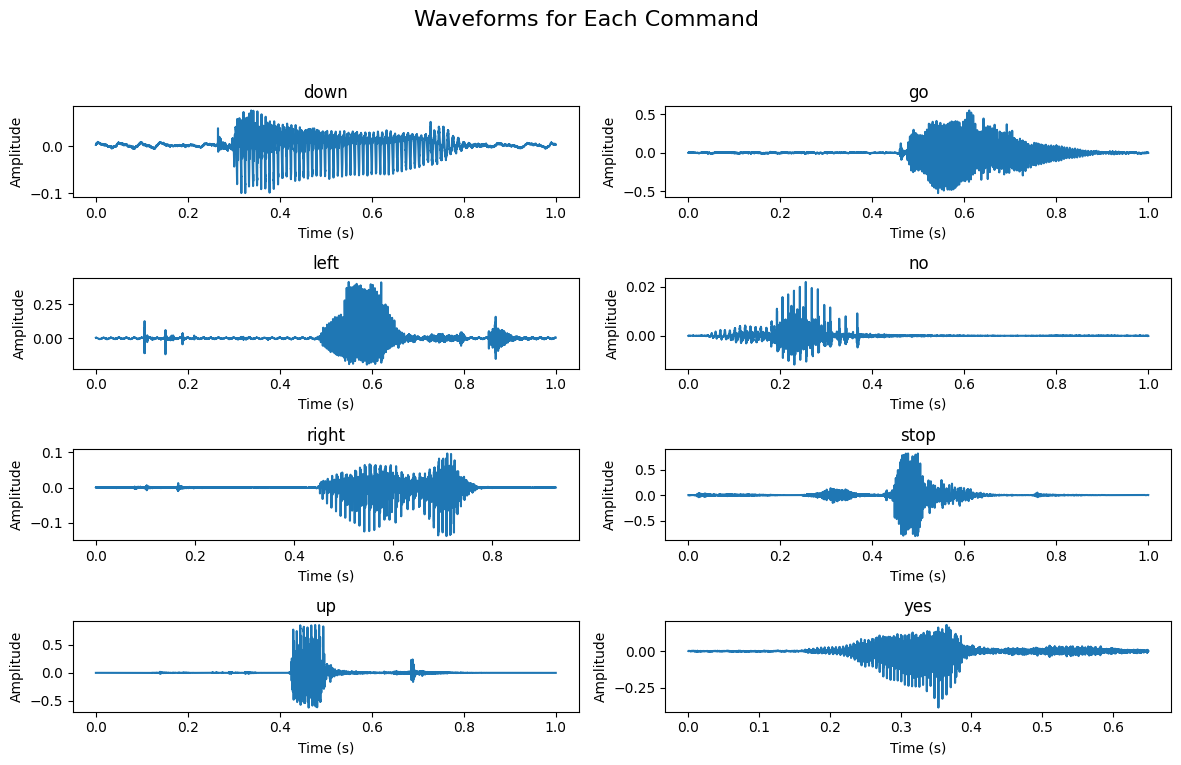

In [6]:
fig, axs = plt.subplots(4, 2, figsize=(12, 8))
fig.suptitle('Waveforms for Each Command', fontsize=16)

# Loop through each command and plot a random audio waveform in a subplot
for i, command in enumerate(commands):
    # Get the list of audio files in the command folder
    command_folder = os.path.join(data_dir, command)
    file_list = tf.io.gfile.listdir(command_folder)

    # Randomly select an audio file from the list
    random_file = random.choice(file_list)
    random_file_path = os.path.join(command_folder, random_file)

    # Read the audio file using the read_sound function
    data, samplerate, time_array = read_sound(random_file_path)

    # Plot the waveform in the current subplot
    axs[i // 2, i % 2].plot(time_array, data)
    axs[i // 2, i % 2].set_title(command)
    axs[i // 2, i % 2].set_xlabel('Time (s)')
    axs[i // 2, i % 2].set_ylabel('Amplitude')
    
# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the subplots
plt.show()

### Display the sound to hear

## `Part 3. Spectrogram analysis`

### A custom spectrogram method for plotting a spectrogram for each random file 

Random a file for plotting

In [7]:
command_1 = commands[np.random.randint(len(commands))]
command_folder = os.path.join(data_dir, command)
file_list = tf.io.gfile.listdir(command_folder)

    # Randomly select an audio file from the list
random_file_1 = random.choice(file_list)
random_file_path_1 = os.path.join(command_folder, random_file_1)

    # Read the audio file using the read_sound function
data_1, samplerate_1, time_array_1 = read_sound(random_file_path_1)

In [8]:
data_1.shape

(16000,)

The brain's response time people (BRT) is about 0.1s. Here we calculate the number of window of the spectrogram based on this value

In [9]:
BRT = 100*10**-3
Nw = samplerate_1*BRT
power_2 = np.ceil(np.log2(Nw))
Nw = 2**power_2
Nw


2048.0

Apply a Hamming window for each window

In [10]:
Nw_window = np.hamming(Nw)

In [11]:
N = len(data_1)
Nsp = int((N - Nw) / (Nw/4)) + 1

spectrogram_matrix = np.zeros((int(Nw), Nsp))
print(spectrogram_matrix.shape)

(2048, 28)


### Calculate the spectro gram matrix

In [12]:
for i in range(Nsp):
    window_start = int(i) * int((int(Nw)/4))
    window_end = window_start + int(Nw)
    window_data = data[window_start:window_end]
    
    # Compute FFT and store in the matrix
    fft_result = np.fft.fft(Nw_window*window_data, int(Nw))
    spectrogram_matrix[:, i] = abs(fft_result)

ValueError: operands could not be broadcast together with shapes (2048,) (1699,) 

In [13]:
signal_size = data_1.size
sampling_rate = samplerate_1

freq = np.arange(signal_size) / signal_size * sampling_rate

In [14]:
freqs = np.arange(Nw)*freq[-1]/Nw
times = np.arange(Nsp)*Nw/4/freq[-1]

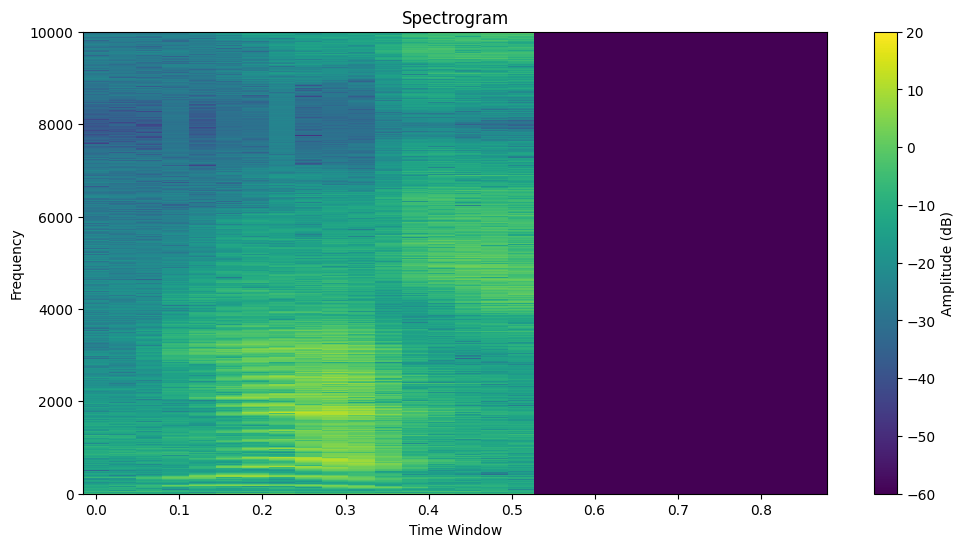

In [15]:
spectrogram_dB = 10 * np.log10(spectrogram_matrix + 1e-9)

plt.figure(figsize=(12, 6))
cax = plt.pcolor(times,freqs, spectrogram_dB, vmin=-60, vmax=20)
plt.colorbar(cax, label='Amplitude (dB)')
plt.xlabel('Time Window')
plt.ylim(0, 10000)
plt.ylabel('Frequency')
plt.title('Spectrogram')
plt.show()

In [16]:
spectrogram_dB.shape

(2048, 28)

#### Define spectrogram processing method 
`using the spectrogram function only` <br> `log scale preprocessing` <br> ` normalized_mel_spectrogram`

### Preprocessing choice = 0,1,2 will be the choice of spectrogram base function, spectrogram log scale, normalized_mel_spectrogram respectively

In [49]:
preproceesing_choice = 1

In [50]:
def spectrogram_fn(input_signal, nfft, window, stride, name=None):
    """
    Create spectrogram from audio.
    Args:
      input_signal: An 1-D audio signal Tensor.
      nfft: Size of FFT.
      window: Size of window.
      stride: Size of hops between windows.
      name: A name for the operation (optional).
    Returns:
      A tensor of spectrogram.
    """

    # TODO: Support audio with channel > 1.
    # Compute the short-time Fourier transform (STFT) of the input signal
    return tf.math.abs(
        tf.signal.stft(
            input_signal,
            frame_length=window,
            frame_step=stride,
            fft_length=nfft,
            window_fn=tf.signal.hann_window,
            pad_end=True,)
            )


def spectrogram_base(x, sr=16000, n_mel_bins=80):
    spec_stride = 128
    spec_len = 1024

    spectrogram = spectrogram_fn(
        x, nfft=spec_len, window=spec_len, stride=spec_stride
    )


    return spectrogram

def spectrogram_log(x, sr=16000, n_mel_bins=80):
    spec_stride = 128
    spec_len = 1024

    spectrogram = spectrogram_fn(
        x, nfft=spec_len, window=spec_len, stride=spec_stride
    )
    spectrogram = tf.math.log(spectrogram + 1e-9)
    
    return spectrogram

def normalized_mel_spectrogram(x, sr=16000, n_mel_bins=80):
    spec_stride = 128
    spec_len = 1024

    spectrogram = spectrogram_fn(
        x, nfft=spec_len, window=spec_len, stride=spec_stride
    )

    num_spectrogram_bins = spec_len // 2 + 1  # spectrogram.shape[-1]
    lower_edge_hertz, upper_edge_hertz = 40.0, 8000.0
    num_mel_bins = n_mel_bins
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
      num_mel_bins, num_spectrogram_bins, sr, lower_edge_hertz,
      upper_edge_hertz)
    mel_spectrograms = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(spectrogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))

    # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)
    avg = tf.math.reduce_mean(log_mel_spectrograms)
    std = tf.math.reduce_std(log_mel_spectrograms)

    return (log_mel_spectrograms - avg) / std

### Put everything into a function

Since the folders are ready, we use
 `keras.utils.audio_dataset_from_directory`.

The audio clips are 1 second or less at 16kHz. The `output_sequence_length=16000` pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

In [43]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,                #The number of audio samples to include in each batch
    validation_split=0.2,         #define the ratio between validation files and total files 
    seed=0,
    output_sequence_length=16000, #define the length of one sound file
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`.

In [44]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [45]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

The `utils.audio_dataset_from_directory` function only returns up to two splits. It's a good idea to keep a test set separate from your validation set.
Ideally you'd keep it in a separate directory, but in this case you can use `Dataset.shard` to split the validation set into two halves. Note that iterating over **any** shard will load **all** the data, and only keep its fraction.

In [46]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [47]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to as [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to [this Coursera video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

Code a new function

In [23]:
def get_spectrogram(waveform):
  if preproceesing_choice == 0:
    spectrogram = (waveform)

    spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [24]:
for i in range(10):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: go
Waveform shape: (16000,)
Spectrogram shape: (125, 513, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (125, 513, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (125, 513, 1)
Audio playback


Label: go
Waveform shape: (16000,)
Spectrogram shape: (125, 513, 1)
Audio playback


Label: yes
Waveform shape: (16000,)
Spectrogram shape: (125, 513, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (125, 513, 1)
Audio playback


Label: right
Waveform shape: (16000,)
Spectrogram shape: (125, 513, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (125, 513, 1)
Audio playback


Label: down
Waveform shape: (16000,)
Spectrogram shape: (125, 513, 1)
Audio playback


Label: down
Waveform shape: (16000,)
Spectrogram shape: (125, 513, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [25]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = spectrogram.T
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

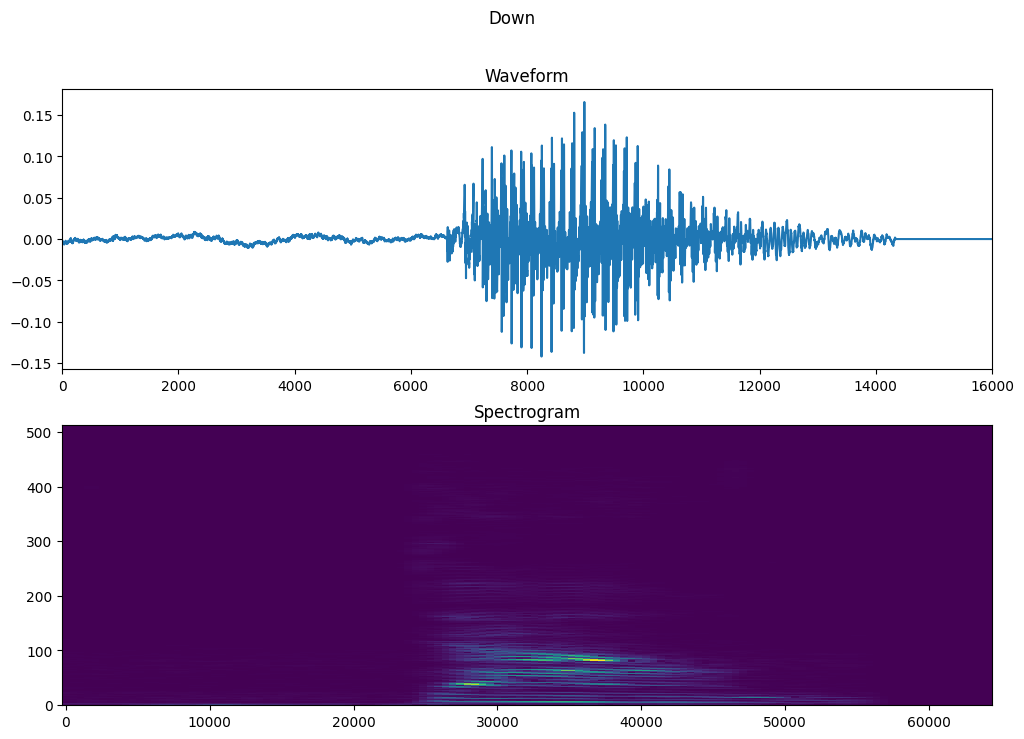

In [26]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, create spectrogramn datasets from the audio datasets:

In [27]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [28]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Examine the spectrograms for different examples of the dataset:

In [29]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

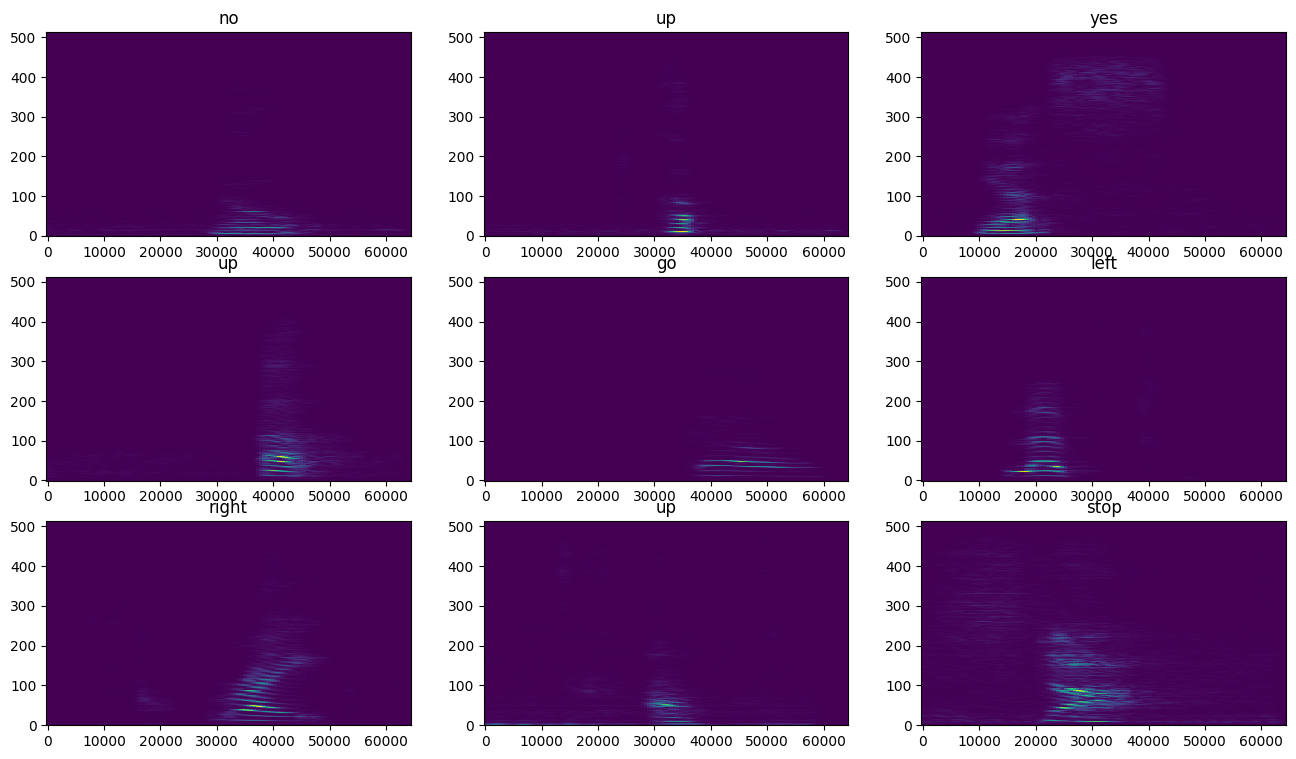

In [30]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## Build and train the model

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [31]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [32]:
from tensorflow.keras import layers as L
from tensorflow.keras import backend as K

In [33]:
import tensorflow as tf
from tensorflow.keras import layers, models

rnn_func = tf.keras.layers.LSTM
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Assuming get_spectrogram function is defined somewhere in your code
norm_layer = tf.keras.layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

# Define the input layer
input_layer = tf.keras.layers.Input(shape=input_shape)

# Resize the input
resized_layer = tf.keras.layers.Resizing(32, 32)(input_layer)

# Normalize the input
normalized_layer = norm_layer(resized_layer)

# Convolutional layers
conv1_layer = tf.keras.layers.Conv2D(32, 3, activation='relu')(normalized_layer)
conv2_layer = tf.keras.layers.Conv2D(64, 3, activation='relu')(conv1_layer)
maxpool_layer = tf.keras.layers.MaxPooling2D()(conv2_layer)
dropout_layer = tf.keras.layers.Dropout(0.25)(maxpool_layer)

# Flatten the output
flatten_layer = tf.keras.layers.Flatten()(dropout_layer)

# Dense layers
dense1_layer = tf.keras.layers.Dense(128, activation='relu')(flatten_layer)
dropout2_layer = tf.keras.layers.Dropout(0.5)(dense1_layer)

# Reshape for LSTM
reshaped_layer = tf.keras.layers.Reshape((-1, 128))(dropout2_layer)

# LSTM layer
lstm_layer = rnn_func(64, return_sequences=True)(reshaped_layer)

# Attention Mechanism
permute1_layer = tf.keras.layers.Permute((2, 1))(lstm_layer)
dense_att_layer = tf.keras.layers.Dense(1, activation='softmax')(permute1_layer)
permute2_layer = tf.keras.layers.Permute((2, 1))(dense_att_layer)
attention_mul_layer = tf.keras.layers.Multiply()([lstm_layer, permute2_layer])

# Flatten the combined output
flatten_attention_layer = tf.keras.layers.Flatten()(attention_mul_layer)

# Additional Dense layers
dense2_layer = tf.keras.layers.Dense(128, activation='relu')(flatten_attention_layer)
dropout3_layer = tf.keras.layers.Dropout(0.5)(dense2_layer)
output_layer = tf.keras.layers.Dense(8, activation='relu')(dropout3_layer)

# Define the model
model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

model.summary()


Input shape: (125, 513, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 125, 513, 1  0           []                               
                                )]                                                                
                                                                                                  
 resizing (Resizing)            (None, 32, 32, 1)    0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 32, 32, 1)    3           ['resizing[0][0]']               
                                                                                                  
 conv2d (Conv2D)                (None, 30, 30, 32)   320         ['

In [34]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)   

In [35]:
EPOCHS = 50
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),)

Epoch 1/50
100/100 [==============================] - 26s 215ms/step - loss: 2.0278 - accuracy: 0.1877 - val_loss: 1.8909 - val_accuracy: 0.3008
Epoch 2/50
100/100 [==============================] - 15s 150ms/step - loss: 1.8263 - accuracy: 0.3013 - val_loss: 1.5725 - val_accuracy: 0.4297
Epoch 3/50
100/100 [==============================] - 13s 128ms/step - loss: 1.5891 - accuracy: 0.3906 - val_loss: 1.3208 - val_accuracy: 0.5130
Epoch 4/50
100/100 [==============================] - 13s 127ms/step - loss: 1.4086 - accuracy: 0.4462 - val_loss: 1.1360 - val_accuracy: 0.5755
Epoch 5/50
100/100 [==============================] - 12s 122ms/step - loss: 1.2558 - accuracy: 0.5123 - val_loss: 1.0318 - val_accuracy: 0.6237
Epoch 6/50
100/100 [==============================] - 12s 122ms/step - loss: 1.1313 - accuracy: 0.5577 - val_loss: 0.9365 - val_accuracy: 0.6589
Epoch 7/50
100/100 [==============================] - 13s 133ms/step - loss: 1.0289 - accuracy: 0.5967 - val_loss: 0.8720 - val_ac

In [36]:
test_loss, test_accuracy = model.evaluate(test_spectrogram_ds)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

13/13 [==============================] - 3s 176ms/step - loss: 0.6720 - accuracy: 0.7885
Test Loss: 0.6720377206802368, Test Accuracy: 0.7884615659713745


In [ ]:
# Assuming you have defined train_spectrogram_ds, val_spectrogram_ds, and test_spectrogram_ds

# Compile the model
model.compile(
    optimizer='adam',  # You can choose another optimizer if needed
    loss='categorical_crossentropy',  # Use 'sparse_categorical_crossentropy' if your labels are integers
    metrics=['accuracy']
)

# Assuming you have defined the number of epochs (num_epochs)
num_epochs = 50

# Train the model
history = model.fit(
    train_spectrogram_ds,
    epochs=num_epochs,
    validation_data=val_spectrogram_ds,
    # Add any other relevant parameters such as callbacks, etc.
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_spectrogram_ds)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


Epoch 1/50


ValueError: in user code:

    File "c:\Users\peter\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\peter\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\peter\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\peter\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\peter\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "c:\Users\peter\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\peter\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\peter\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\peter\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py", line 2004, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "c:\Users\peter\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\backend.py", line 5532, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 8) are incompatible


In [ ]:
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_30 (Resizing)      (None, 32, 32, 1)         0         
                                                                 
 normalization_28 (Normaliza  (None, 32, 32, 1)        3         
 tion)                                                           
                                                                 
 conv2d_58 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 conv2d_59 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 dropout_80 (Dropout)        (None, 14, 14, 64)      

In [ ]:
rnn_func=L.LSTM
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model_simple = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model_simple.summary()
    

Input shape: (125, 80, 1)
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_31 (Resizing)      (None, 32, 32, 1)         0         
                                                                 
 normalization_29 (Normaliza  (None, 32, 32, 1)        3         
 tion)                                                           
                                                                 
 conv2d_60 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 conv2d_61 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 dropout_83 (Dropout)      

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [ ]:
model_simple.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Train the model over 10 epochs for demonstration purposes:

In [ ]:
EPOCHS = 50
history = model_simple.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)

Epoch 1/50


 14/100 [===>..........................] - ETA: 12s - loss: 2.0916 - accuracy: 0.1741

KeyboardInterrupt: 

Let's plot the training and validation loss curves to check how your model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

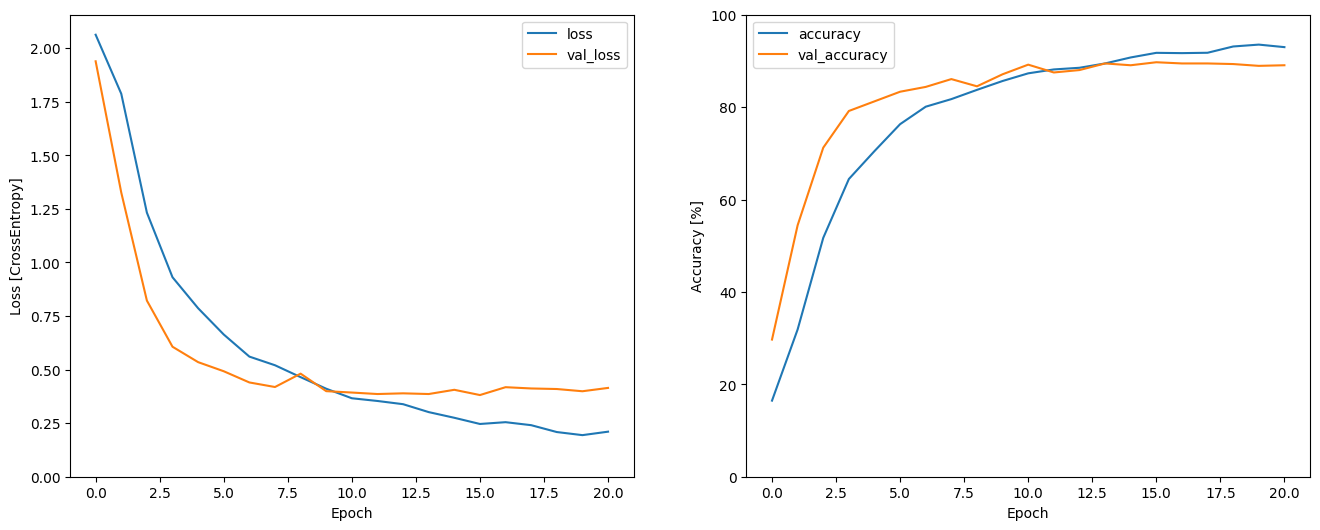

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [ ]:
model.evaluate(test_spectrogram_ds, return_dict=True)

 3/13 [=====>........................] - ETA: 0s - loss: 0.6328 - accuracy: 0.8281

13/13 [==============================] - 0s 31ms/step - loss: 0.4221 - accuracy: 0.8762


{'loss': 0.4220913052558899, 'accuracy': 0.8762019276618958}

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


In [ ]:
y_pred = model.predict(test_spectrogram_ds)

13/13 [==============================] - 1s 28ms/step


In [ ]:
y_pred = tf.argmax(y_pred, axis=1)

In [ ]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

### Plot confusion matrix

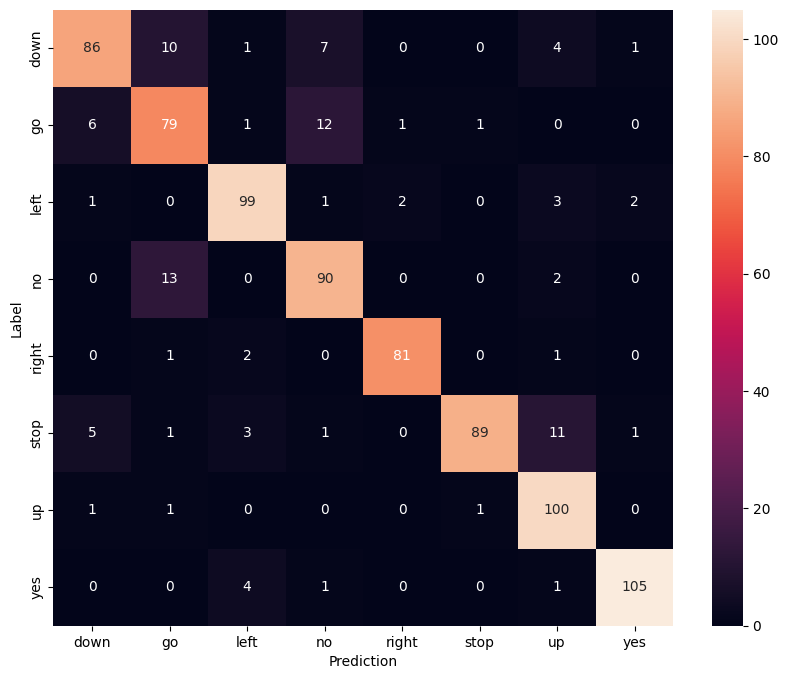

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

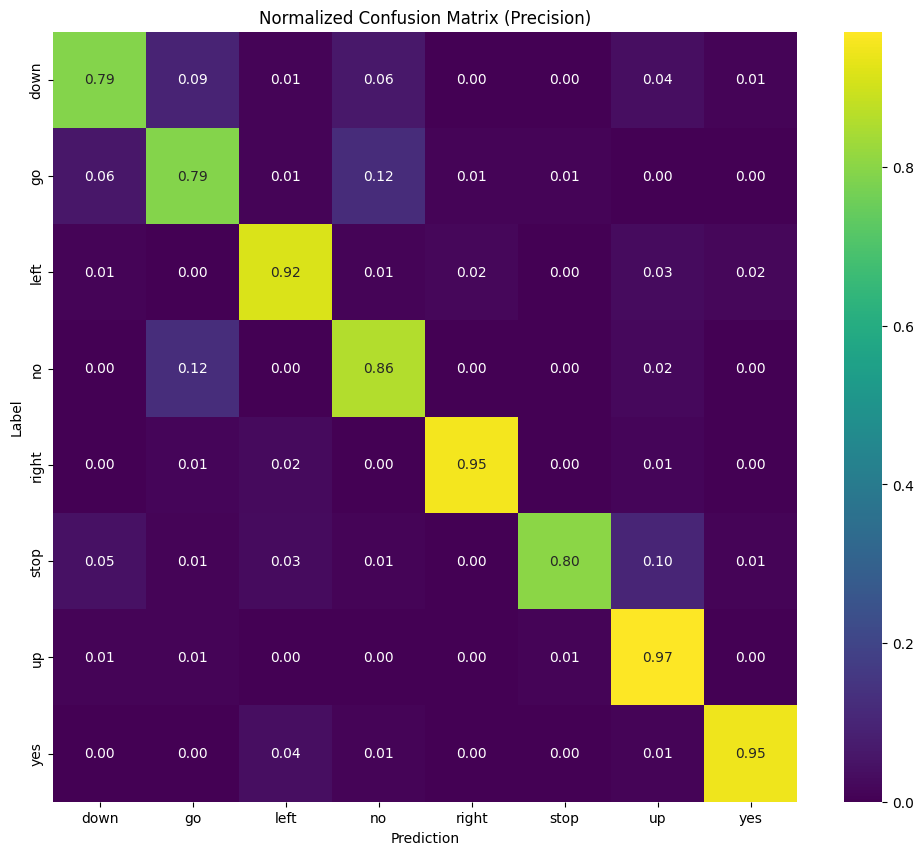

In [ ]:

# Compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)

# Normalize each row to have a sum of 1 (precision)
confusion_mtx_normalized = confusion_mtx / tf.reduce_sum(confusion_mtx, axis=1, keepdims=True)

# Plot the normalized confusion matrix (precision)
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_mtx_normalized,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='.2f', cmap='viridis')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title('Normalized Confusion Matrix (Precision)')
plt.show()


## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

In [ ]:
import sounddevice as sd
import soundfile as sf
import pyautogui

In [ ]:
def record_and_process_audio(duration, sample_rate, target_duration=1.0):
    # Record audio
    audio = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1, dtype='float32')
    sd.wait()  # Wait until recording is finished

    # Calculate the target number of samples
    target_samples = int(target_duration * sample_rate)

    # Pad the audio if it's shorter than the target
    if audio.shape[0] < target_samples:
        padding = np.zeros((target_samples - audio.shape[0], audio.shape[1]))
        audio = np.vstack((audio, padding))
    return audio


def predict_command(audio):
    audio = audio.astype(np.float32)
    tensor = tf.convert_to_tensor(audio)
    x = tf.squeeze(tensor, axis=-1)

    # waveform = x  # Assuming waveform is needed for your processing
    x = normalized_mel_spectrogram(x)
    x = x[tf.newaxis, ...]

    prediction = model(x)
    probabilities = tf.nn.softmax(prediction[0])
    predicted_index = tf.argmax(probabilities).numpy()
    print(probabilities[predicted_index])
    print(probabilities)
    x_labels = ['down', 'left', 'nothing', 'right', 'up']
    return x_labels[predicted_index]

try:
    while True:
        print("Recording...")
        audio = record_and_process_audio(1, 16000)  # Recording for 0.3 seconds at 16000 Hz sample rate
        predicted_label = predict_command(audio)
        print(f"Predicted command: {predicted_label}")

#         # Execute the command
#         if predicted_label == 'left':
#             pyautogui.press('left')
#         elif predicted_label == 'right':
#             pyautogui.press('right')
#         elif predicted_label == 'up':
#             pyautogui.press('up')
#         elif predicted_label == 'down':
#             pyautogui.press('down')
            
except KeyboardInterrupt:
    print("Stopped by user.")



Recording...
tf.Tensor(0.99999344, shape=(), dtype=float32)
tf.Tensor([2.9344565e-07 6.0889206e-06 1.5308900e-07 9.9999344e-01], shape=(4,), dtype=float32)
Predicted command: up
Recording...
tf.Tensor(0.99997604, shape=(), dtype=float32)
tf.Tensor([4.7705521e-07 2.3524461e-05 3.0131041e-08 9.9997604e-01], shape=(4,), dtype=float32)
Predicted command: up
Recording...
tf.Tensor(0.9999502, shape=(), dtype=float32)
tf.Tensor([1.9717609e-06 4.7370486e-05 5.8676045e-07 9.9995017e-01], shape=(4,), dtype=float32)
Predicted command: up
Recording...
tf.Tensor(0.99993, shape=(), dtype=float32)
tf.Tensor([5.6649396e-06 6.4038795e-05 2.8479604e-07 9.9993002e-01], shape=(4,), dtype=float32)
Predicted command: up
Recording...
tf.Tensor(0.9999362, shape=(), dtype=float32)
tf.Tensor([4.6032951e-06 5.8371334e-05 7.9162351e-07 9.9993622e-01], shape=(4,), dtype=float32)
Predicted command: up
Recording...
tf.Tensor(0.99996436, shape=(), dtype=float32)
tf.Tensor([4.8912439e-06 3.0591244e-05 1.7354664e-07 9.

data\down
['down_full_10.wav', 'down_full_100.wav', 'down_full_101.wav', 'down_full_102.wav', 'down_full_103.wav', 'down_full_104.wav', 'down_full_105.wav', 'down_full_106.wav', 'down_full_110.wav', 'down_full_111.wav', 'down_full_112.wav', 'down_full_114.wav', 'down_full_120.wav', 'down_full_121.wav', 'down_full_122.wav', 'down_full_125.wav', 'down_full_126.wav', 'down_full_127.wav', 'down_full_128.wav', 'down_full_133.wav', 'down_full_134.wav', 'down_full_136.wav', 'down_full_14.wav', 'down_full_17.wav', 'down_full_22.wav', 'down_full_26.wav', 'down_full_27.wav', 'down_full_29.wav', 'down_full_30.wav', 'down_full_32.wav', 'down_full_35.wav', 'down_full_38.wav', 'down_full_41.wav', 'down_full_44.wav', 'down_full_45.wav', 'down_full_46.wav', 'down_full_47.wav', 'down_full_48.wav', 'down_full_52.wav', 'down_full_59.wav', 'down_full_60.wav', 'down_full_61.wav', 'down_full_64.wav', 'down_full_65.wav', 'down_full_7.wav', 'down_full_71.wav', 'down_full_72.wav', 'down_full_73.wav', 'down_ful

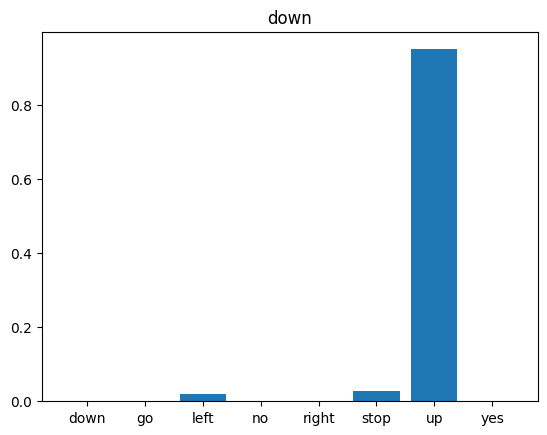

data\left
['left_full_100.wav', 'left_full_101.wav', 'left_full_102.wav', 'left_full_103.wav', 'left_full_106.wav', 'left_full_109.wav', 'left_full_111.wav', 'left_full_113.wav', 'left_full_114.wav', 'left_full_115.wav', 'left_full_116.wav', 'left_full_120.wav', 'left_full_122.wav', 'left_full_123.wav', 'left_full_124.wav', 'left_full_125.wav', 'left_full_127.wav', 'left_full_128.wav', 'left_full_129.wav', 'left_full_131.wav', 'left_full_134.wav', 'left_full_135.wav', 'left_full_137.wav', 'left_full_138.wav', 'left_full_141.wav', 'left_full_142.wav', 'left_full_143.wav', 'left_full_16.wav', 'left_full_17.wav', 'left_full_18.wav', 'left_full_21.wav', 'left_full_22.wav', 'left_full_25.wav', 'left_full_26.wav', 'left_full_27.wav', 'left_full_28.wav', 'left_full_29.wav', 'left_full_30.wav', 'left_full_31.wav', 'left_full_32.wav', 'left_full_33.wav', 'left_full_34.wav', 'left_full_37.wav', 'left_full_4.wav', 'left_full_48.wav', 'left_full_49.wav', 'left_full_5.wav', 'left_full_50.wav', 'lef

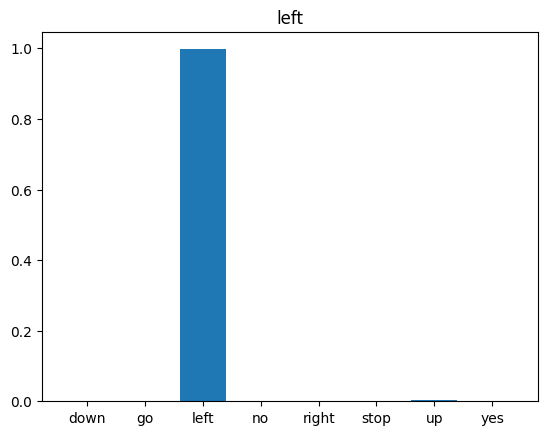

data\right
['right_full_102.wav', 'right_full_103.wav', 'right_full_105.wav', 'right_full_106.wav', 'right_full_107.wav', 'right_full_108.wav', 'right_full_109.wav', 'right_full_111.wav', 'right_full_114.wav', 'right_full_115.wav', 'right_full_116.wav', 'right_full_117.wav', 'right_full_119.wav', 'right_full_120.wav', 'right_full_121.wav', 'right_full_122.wav', 'right_full_123.wav', 'right_full_124.wav', 'right_full_125.wav', 'right_full_129.wav', 'right_full_130.wav', 'right_full_131.wav', 'right_full_132.wav', 'right_full_134.wav', 'right_full_135.wav', 'right_full_136.wav', 'right_full_139.wav', 'right_full_140.wav', 'right_full_141.wav', 'right_full_145.wav', 'right_full_146.wav', 'right_full_147.wav', 'right_full_151.wav', 'right_full_152.wav', 'right_full_154.wav', 'right_full_155.wav', 'right_full_156.wav', 'right_full_157.wav', 'right_full_159.wav', 'right_full_160.wav', 'right_full_161.wav', 'right_full_164.wav', 'right_full_165.wav', 'right_full_167.wav', 'right_full_169.wav'

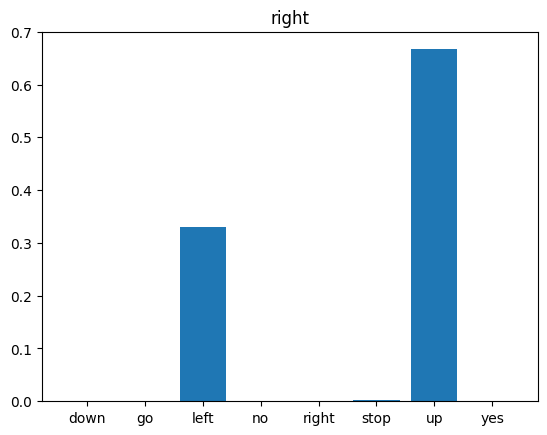

In [ ]:
TEST_PATH = './data'

test_dir = pathlib.Path(TEST_PATH)
commands = np.array(tf.io.gfile.listdir(str(test_dir)))
for i,command in enumerate(commands):
    command_folder = os.path.join(test_dir, command)
    print(command_folder)
    file_list = tf.io.gfile.listdir(command_folder)
    print(file_list)
        # Randomly select an audio file from the list
    random_file = random.choice(file_list)
    print(random_file)
    random_file_path = os.path.join(command_folder, random_file)

    print(random_file_path)

    x = random_file_path

    x = tf.io.read_file(x)
    # print(x)
    # print(x.shape)
    x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
    x = tf.squeeze(x, axis=-1)
    waveform = x
    x = get_spectrogram(x)
    x = x[tf.newaxis,...]
    prediction = model(x)
    x_labels = ['down', 'go', 'left', 'no' ,'right', 'stop','up','yes']
    plt.bar(x_labels, tf.nn.softmax(prediction[0]))
    plt.title(command)
    plt.show()

    display.display(display.Audio(waveform, rate=16000))

In [ ]:
def record_and_process_audio(duration, sample_rate, target_duration=1.0):
    # Record audio
    audio = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1, dtype='float32')
    sd.wait()  # Wait until recording is finished

    # Calculate the target number of samples
    target_samples = int(target_duration * sample_rate)

    # Pad the audio if it's shorter than the target
    if audio.shape[0] < target_samples:
        padding = np.zeros((target_samples - audio.shape[0], audio.shape[1]))
        audio = np.vstack((audio, padding))
    return audio


def predict_command(audio):
    audio = audio.astype(np.float32)
    tensor = tf.convert_to_tensor(audio)
    x = tf.squeeze(tensor, axis=-1)

    # waveform = x  # Assuming waveform is needed for your processing
    x = normalized_mel_spectrogram(x)
    x = x[tf.newaxis, ...]

    prediction = model(x)
    probabilities = tf.nn.softmax(prediction[0])
    predicted_index = tf.argmax(probabilities).numpy()
    print(probabilities[predicted_index])
    print(probabilities)
    x_labels = commands
    return x_labels[predicted_index]

try:
    while True:
        print("Recording...")
        audio = record_and_process_audio(1, 16000)  # Recording for 0.3 seconds at 16000 Hz sample rate
        predicted_label = predict_command(audio)
        print(f"Predicted command: {predicted_label}")

except KeyboardInterrupt:
    print("Stopped by user.")



Recording...
tf.Tensor(0.48435074, shape=(), dtype=float32)
tf.Tensor(
[0.04177646 0.41656736 0.01052585 0.48435074 0.01052585 0.01052585
 0.01520204 0.01052585], shape=(8,), dtype=float32)
Predicted command: no
Recording...
tf.Tensor(0.6745588, shape=(), dtype=float32)
tf.Tensor(
[0.01313984 0.05755149 0.05021587 0.01313984 0.16511443 0.01313984
 0.6745588  0.01313984], shape=(8,), dtype=float32)
Predicted command: up
Recording...
tf.Tensor(0.726589, shape=(), dtype=float32)
tf.Tensor(
[0.03347356 0.20255014 0.00997047 0.726589   0.00724006 0.00658965
 0.00658965 0.00699754], shape=(8,), dtype=float32)
Predicted command: no
Recording...
tf.Tensor(0.45997983, shape=(), dtype=float32)
tf.Tensor(
[0.03918841 0.18639022 0.16040206 0.45997983 0.06677046 0.026429
 0.02977415 0.03106586], shape=(8,), dtype=float32)
Predicted command: no
Recording...
tf.Tensor(0.4131224, shape=(), dtype=float32)
tf.Tensor(
[0.06589866 0.01794543 0.17747414 0.4131224  0.01672774 0.01832604
 0.01672774 0.273777

As the output suggests, your model should have recognized the audio command as "no".

## Export the model with preprocessing

The model's not very easy to use if you have to apply those preprocessing steps before passing data to the model for inference. So build an end-to-end version:

In [ ]:
import numpy as np
list_1 = np.arange(1,10**6,3)
list_1

array([     1,      4,      7, ..., 999991, 999994, 999997])

In [ ]:
list(set(list_1))

[1,
 4,
 7,
 10,
 13,
 16,
 19,
 22,
 25,
 28,
 31,
 34,
 37,
 40,
 43,
 46,
 49,
 52,
 55,
 58,
 61,
 64,
 67,
 70,
 73,
 76,
 79,
 82,
 85,
 88,
 91,
 94,
 97,
 100,
 103,
 106,
 109,
 112,
 115,
 118,
 121,
 124,
 127,
 130,
 133,
 136,
 139,
 142,
 145,
 148,
 151,
 154,
 157,
 160,
 163,
 166,
 169,
 172,
 175,
 178,
 181,
 184,
 187,
 190,
 193,
 196,
 199,
 202,
 205,
 208,
 211,
 214,
 217,
 220,
 223,
 226,
 229,
 232,
 235,
 238,
 241,
 244,
 247,
 250,
 253,
 256,
 259,
 262,
 265,
 268,
 271,
 274,
 277,
 280,
 283,
 286,
 289,
 292,
 295,
 298,
 301,
 304,
 307,
 310,
 313,
 316,
 319,
 322,
 325,
 328,
 331,
 334,
 337,
 340,
 343,
 346,
 349,
 352,
 355,
 358,
 361,
 364,
 367,
 370,
 373,
 376,
 379,
 382,
 385,
 388,
 391,
 394,
 397,
 400,
 403,
 406,
 409,
 412,
 415,
 418,
 421,
 424,
 427,
 430,
 433,
 436,
 439,
 442,
 445,
 448,
 451,
 454,
 457,
 460,
 463,
 466,
 469,
 472,
 475,
 478,
 481,
 484,
 487,
 490,
 493,
 496,
 499,
 502,
 505,
 508,
 511,
 514,
 517

In [ ]:
list_2 = np.arange(1,10**6,7)
list_2

array([     1,      8,     15, ..., 999979, 999986, 999993])

In [ ]:
list_3 = np.concatenate((list_1, list_2))


In [ ]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch.
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it.
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

Test run the "export" model:

In [ ]:
export = ExportModel(model)
export(tf.constant(str(data_dir/'left/00b01445_nohash_0.wav')))

{'predictions': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 1.2582613, 11.812878 , -5.5495043, -1.4444207]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1], dtype=int64)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'left'], dtype=object)>}

Save and reload the model, the reloaded model gives identical output:

In [ ]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

INFO:tensorflow:Assets written to: saved\assets


INFO:tensorflow:Assets written to: saved\assets


{'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0], dtype=int64)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'down'], dtype=object)>,
 'predictions': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 1.7262106,  1.1506386, -2.0522597, -0.4897965]], dtype=float32)>}

## Next steps

This tutorial demonstrated how to carry out simple audio classification/automatic speech recognition using a convolutional neural network with TensorFlow and Python. To learn more, consider the following resources:

- The [Sound classification with YAMNet](https://www.tensorflow.org/hub/tutorials/yamnet) tutorial shows how to use transfer learning for audio classification.
- The notebooks from [Kaggle's TensorFlow speech recognition challenge](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/overview).
- The
[TensorFlow.js - Audio recognition using transfer learning codelab](https://codelabs.developers.google.com/codelabs/tensorflowjs-audio-codelab/index.html#0) teaches how to build your own interactive web app for audio classification.
- [A tutorial on deep learning for music information retrieval](https://arxiv.org/abs/1709.04396) (Choi et al., 2017) on arXiv.
- TensorFlow also has additional support for [audio data preparation and augmentation](https://www.tensorflow.org/io/tutorials/audio) to help with your own audio-based projects.
- Consider using the [librosa](https://librosa.org/) library for music and audio analysis.

In [ ]:
file_to_down = [file for file in os.listdir('/content/saved')]
file_to_down

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/saved'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%cd /content/saved

/content/saved


In [ ]:
!zip -r saved_model.zip . -i content/saved/

	zip warning: zip file empty


In [ ]:
!zip -r /content/saved.zip /content/saved/

  adding: content/saved/ (stored 0%)
  adding: content/saved/saved_model.zip (stored 0%)
  adding: content/saved/fingerprint.pb (stored 0%)
  adding: content/saved/variables/ (stored 0%)
  adding: content/saved/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/saved/variables/variables.index (deflated 62%)
  adding: content/saved/assets/ (stored 0%)
  adding: content/saved/saved_model.pb (deflated 86%)


In [ ]:
files.download('/content/saved.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

# Specify the path of the file you want to download
file_path = "saved"  # Update this with the actual file path

# Trigger the download
files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

file_path = "/content/saved"
files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>